In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from shutil import copy
from collections import defaultdict
import scipy
import numpy as np
import matplotlib.pyplot as plt

import random
#import cv2
import glob
from PIL import Image, ImageEnhance
import PIL.ImageOps

#import torch
#import torchvision
#from torch import nn

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Theano(th)와 Tensorflow(tf) 모두와 호환이 되는 Keras 모듈을 작성
import keras.backend as K
from keras import regularizers
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout, Conv2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator # 데이터 전처리
from keras.callbacks import ModelCheckpoint, CSVLogger
#from keras.optimizers import SGD

from keras_preprocessing.image import array_to_img, img_to_array, load_img

print(tf.test.gpu_device_name())

/device:GPU:0Metal device set to: Apple M1



## 기본 세팅

In [3]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


## data 불러오기 + split

In [4]:
import tensorflow_datasets as tfds

(train_ds1,train_ds2,train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:40%]','train[40%:80%]','train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /Users/kyungseonlee/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
num_classes = metadata.features['label'].num_classes

print(num_classes)

5


In [5]:
metadata.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
metadata.features['label'].str2int

<bound method ClassLabel.str2int of ClassLabel(shape=(), dtype=tf.int64, num_classes=5)>

In [7]:
get_label_name = metadata.features['label'].int2str

print(get_label_name)

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=5)>


In [96]:
train_ds2.element_spec[1]

TypeError: 'TensorSpec' object is not iterable

tf.Tensor(0, shape=(), dtype=int64)


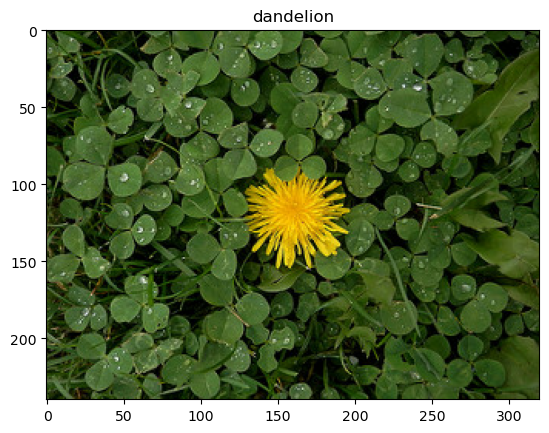

In [100]:

image, label = next(iter(train_ds2))

print(label)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))


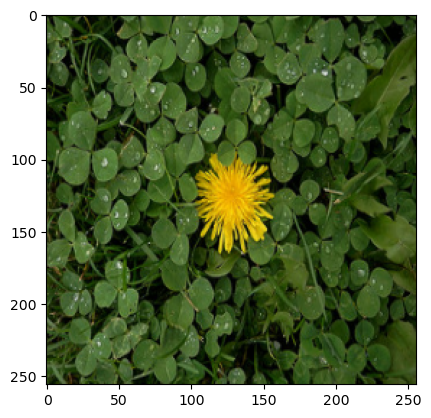

In [101]:
IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

result = resize_and_rescale(image)
_ = plt.imshow(result)

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
batch_size = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds,shuffle=False ,augment=False):
  # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

  # Batch all datasets
    ds = ds.batch(batch_size)
    
    
  # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
train=prepare(train_ds,shuffle=True, augment=True)
train1 = prepare(train_ds1,shuffle=True, augment=True)
train2 = prepare(train_ds2, shuffle=True, augment=True)
validation = prepare(val_ds)
test = prepare(test_ds)

In [13]:
print(train1)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [94]:
train_np=tfds.as_numpy(train)
np.save('../../flower_np/train_np.npy')

- train1,train2:1468, validation,test: 367

## 모델 기본 세팅

In [21]:
from deeplab2.model.pixel_encoder import moat

In [22]:
# releases the global state: avoid clutter from old models and layers
K.clear_session()

## 모델1 Disjoint two model

In [23]:
from tensorflow.keras.layers import (Input, Dense, concatenate, Conv2D, MaxPooling2D, Flatten)
from tensorflow import keras

from AdaBelief_tf import AdaBeliefOptimizer
opt = AdaBeliefOptimizer(learning_rate=5e-4, beta_1= 0.9, beta_2=0.999, weight_decay= 1e-4,  epsilon=1e-14, rectify=True)

# tf.keras.optimizers.schedules.LearningRateSchedule 나중에. 오목한 형태로 하는게 좋을듯 함.

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [24]:
nb_train_samples =  1468*2
nb_train1_samples =  1468
nb_train2_samples =  1468  
nb_validation_samples = 367
nb_validation2_samples = 367   
nb_test_samples = 367  
batch_size = 16

### model1

In [25]:
moat1 = moat.get_model(name='tiny_moat1_pretrain_256_no_pe_1k',input_shape=[256,256,3])
moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./moat1/model-ckpt-0")
o1 = moat1.output["stage5"]
r1 = tf.keras.layers.Flatten(name='flatten_layer1')(o1)
out1 = tf.keras.layers.Dense(
    units=5, activation='softmax', name='output_layer')(r1)

def create_model():
    return tf.keras.models.Model(moat1.input, out1)

In [27]:
with tf.device('/device:GPU:0'):
    model1=create_model()
#    model1.load_weights('flower_moat1_3.h5')
  #  moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./moat1/model-ckpt-0")
    opt2 = AdaBeliefOptimizer(learning_rate=1e-6, beta_1= 0.9, beta_2=0.999, weight_decay= 0.05,  epsilon=1e-14)
    model1.compile(optimizer=opt2,
                   loss='sparse_categorical_crossentropy', 
                   metrics = tf.keras.metrics.SparseCategoricalAccuracy())
#    checkpointer = ModelCheckpoint(filepath='flower_disjoint1_1.hdf5', 
#                                   verbose=1, 
#                                   monitor ="val_sparse_categorical_accuracy",
#                                   save_best_only=True)
#    csv_logger = CSVLogger('flower_disjoint1_1.log')

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [28]:
print(tf.__version__)

2.10.0


In [29]:
with tf.device('/device:GPU:0'):
    history = model1.fit_generator(train1,
      #              steps_per_epoch = nb_train1_samples // batch_size,      
                    validation_data=validation,
      #              validation_steps=nb_validation_samples // batch_size,  
                    epochs=100,verbose=1)

/var/folders/sc/618cfvvs4dq7jx43m7fskwjw0000gn/T/ipykernel_78346/3961940557.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train1,


Epoch 1/100
  8/147 [>.............................] - ETA: 16:47 - loss: 11.2095 - sparse_categorical_accuracy: 0.2500

KeyboardInterrupt: 

In [63]:
moat1.save_weights('final_flower_moat1_4.h5')

- 'flower_moat1_final_disjoint1_1.hdf5' 가 82/83 으로 마무리 
- 'flower_moat1_4.h5' 가 94/91로 마무리.

### model2

In [46]:
moat2 = moat.get_model(name='tiny_moat1_pretrain_256_no_pe_1k',input_shape=[256,256,3])
moat2 = moat._load_moat_pretrained_checkpoint(moat1, path="./moat1/model-ckpt-0")
o2 = moat2.output["stage5"]
r2 = tf.keras.layers.Flatten(name='flatten_layer1')(o2)
out2 = tf.keras.layers.Dense(
    units=5, activation='softmax', name='output_layer')(r2)

def create_model():
    return tf.keras.models.Model(moat2.input, out2)

In [47]:
with tf.device('/device:GPU:2'):
    model2=create_model()
 #   model2.load_weights('flower_moat1_2.h5')
  #  moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./moat1/model-ckpt-0")
    opt2 = AdaBeliefOptimizer(learning_rate=1e-6, beta_1= 0.9, beta_2=0.999, weight_decay= 0.05,  epsilon=1e-14)
    model2.compile(optimizer=opt2,
                   loss='sparse_categorical_crossentropy', 
                   metrics = tf.keras.metrics.SparseCategoricalAccuracy())
#    checkpointer = ModelCheckpoint(filepath='flower_disjoint1_1.hdf5', 
#                                   verbose=1, 
#                                   monitor ="val_sparse_categorical_accuracy",
#                                   save_best_only=True)
#    csv_logger = CSVLogger('flower_disjoint1_1.log')

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [48]:
print(tf.__version__)

2.6.0


In [49]:
with tf.device('/device:GPU:2'):
    history = model2.fit_generator(train2,
      #              steps_per_epoch = nb_train1_samples // batch_size,      
                    validation_data=validation,
      #              validation_steps=nb_validation_samples // batch_size,  
                    epochs=313,verbose=1)

Epoch 1/313
147/147 [==============================] - 259s 830ms/step - loss: 8.9507 - sparse_categorical_accuracy: 0.2112 - val_loss: 7.4043 - val_sparse_categorical_accuracy: 0.2834
Epoch 2/313
147/147 [==============================] - 124s 826ms/step - loss: 7.0148 - sparse_categorical_accuracy: 0.1989 - val_loss: 5.5012 - val_sparse_categorical_accuracy: 0.2725
Epoch 3/313
147/147 [==============================] - 119s 781ms/step - loss: 5.1455 - sparse_categorical_accuracy: 0.2166 - val_loss: 4.2067 - val_sparse_categorical_accuracy: 0.2997
Epoch 4/313
147/147 [==============================] - 127s 842ms/step - loss: 4.3484 - sparse_categorical_accuracy: 0.2432 - val_loss: 3.7410 - val_sparse_categorical_accuracy: 0.3297
Epoch 5/313
147/147 [==============================] - 119s 793ms/step - loss: 3.9450 - sparse_categorical_accuracy: 0.2868 - val_loss: 3.4561 - val_sparse_categorical_accuracy: 0.3488
Epoch 6/313
147/147 [==============================] - 121s 794ms/step - lo

KeyboardInterrupt: 

In [62]:
moat2.save_weights('final_flower_moat2_1.h5')

- 모델2 95/90 달성

## 앙상블 V1

In [77]:
moat3 = moat.get_model(name='tiny_moat1_pretrain_256_no_pe_1k',input_shape=[256,256,3])
moat4 = moat.get_model(name='tiny_moat1_pretrain_256_no_pe_1k',input_shape=[256,256,3])
moat3._name="moat3"
moat4._name="moat4"

for layer in moat4.layers:
    layer._name = layer.name + str("_2")

In [78]:
moat3.load_weights('final_flower_moat1_4.h5')
moat4.load_weights('final_flower_moat2_1.h5')

moat3.trainable=False
moat4.trainable=False

In [79]:
en_input = Input(shape=(256,256,3))
x = moat3(en_input)
y = moat4(en_input)

b1 = tf.keras.layers.Flatten(name='flatten_layer1')(x["stage5"])
b2 = tf.keras.layers.Flatten(name='flatten_layer2')(y["stage5"])

z= tf.concat([b1, b2],axis=1)

l= Dense(units=256, activation='gelu')(z)
en_out = Dense(units=5, activation='softmax')(l)

In [80]:
def create_model3():
    return tf.keras.models.Model(inputs=en_input, outputs=en_out) 

#moat2 = moat.get_model(
#    name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[256,256,3])
#moat2 = moat._load_moat_pretrained_checkpoint(moat1, path="./model-ckpt-0")

opt2 = AdaBeliefOptimizer(learning_rate=5e-4, beta_1= 0.9, beta_2=0.999, weight_decay= 0.05,  epsilon=1e-14, clipnorm=1)

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [79]:
with tf.device('/device:GPU:2'):
    en_model = create_model3()
    en_model.compile(optimizer=opt2,
              loss='sparse_categorical_crossentropy', metrics = tf.keras.metrics.SparseCategoricalAccuracy())
#    checkpointer = ModelCheckpoint(filepath='ensemble_1.hdf5', verbose=1, save_best_only=True)
#    csv_logger = CSVLogger('ensemble_1.hdf5.log')
    history = en_model.fit_generator(train, 
  #                  steps_per_epoch = nb_train_samples // batch_size,      
                    validation_data=validation,
  #                  validation_steps=nb_validation_samples // batch_size,  
                    epochs=100,                                             
                    verbose=1)

Epoch 1/100
184/184 [==============================] - 85s 262ms/step - loss: 2.5346 - sparse_categorical_accuracy: 0.8007 - val_loss: 1.9284 - val_sparse_categorical_accuracy: 0.8501
Epoch 2/100
184/184 [==============================] - 44s 225ms/step - loss: 1.9473 - sparse_categorical_accuracy: 0.8638 - val_loss: 1.0403 - val_sparse_categorical_accuracy: 0.9155
Epoch 3/100
184/184 [==============================] - 45s 235ms/step - loss: 1.4252 - sparse_categorical_accuracy: 0.8954 - val_loss: 3.3255 - val_sparse_categorical_accuracy: 0.8365
Epoch 4/100
184/184 [==============================] - 44s 232ms/step - loss: 1.3365 - sparse_categorical_accuracy: 0.9114 - val_loss: 1.6143 - val_sparse_categorical_accuracy: 0.8556
Epoch 5/100
184/184 [==============================] - 42s 222ms/step - loss: 0.9660 - sparse_categorical_accuracy: 0.9128 - val_loss: 0.9537 - val_sparse_categorical_accuracy: 0.8965
Epoch 6/100
184/184 [==============================] - 42s 223ms/step - loss: 0.

KeyboardInterrupt: 

In [80]:
en_model.save_weights('final_flower_en_1.h5')

- 96/87 도달

-----
## full model training

In [81]:
moat5 = moat.get_model(name='tiny_moat1_pretrain_256_no_pe_1k',input_shape=[256,256,3])
moat6 = moat.get_model(name='tiny_moat1_pretrain_256_no_pe_1k',input_shape=[256,256,3])
moat5._name="moat3"
moat6._name="moat4"

for layer in moat6.layers:
    layer._name = layer.name + str("_2")

In [82]:
'''
moat5.load_weights('final_flower_moat1_4.h5')
moat6.load_weights('final_flower_moat2_1.h5')
'''
moat5.trainable=False
moat6.trainable=False


In [83]:
full_input = Input(shape=(256,256,3))
x = moat5(full_input)
y = moat6(full_input)

b1 = tf.keras.layers.Flatten(name='flatten_layer1')(x["stage5"])
b2 = tf.keras.layers.Flatten(name='flatten_layer2')(y["stage5"])

z= tf.concat([b1, b2],axis=1)

l= Dense(units=256, activation='gelu')(z)
full_out = Dense(units=5, activation='softmax')(l)

In [84]:
def create_model3():
    return tf.keras.models.Model(inputs=full_input, outputs=full_out) 

#moat2 = moat.get_model(
#    name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[256,256,3])
#moat2 = moat._load_moat_pretrained_checkpoint(moat1, path="./model-ckpt-0")

opt2 = AdaBeliefOptimizer(learning_rate=5e-4, beta_1= 0.9, beta_2=0.999, weight_decay= 0.05,  epsilon=1e-14, clipnorm=1)

full_model = create_model3()
full_model.compile(optimizer=opt2,
              loss='sparse_categorical_crossentropy', metrics = tf.keras.metrics.SparseCategoricalAccuracy())
full_model.load_weights('final_flower_en_1.h5')

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [85]:
'''
moat5.load_weights('final_flower_moat1_4.h5')
moat6.load_weights('final_flower_moat2_1.h5')
'''
moat3.trainable=True
moat4.trainable=True


In [86]:
with tf.device('/device:GPU:0'):
    
#    checkpointer = ModelCheckpoint(filepath='ensemble_1.hdf5', verbose=1, save_best_only=True)
#    csv_logger = CSVLogger('ensemble_1.hdf5.log')

    history = full_model.fit_generator(train, 
  #                  steps_per_epoch = nb_train_samples // batch_size,      
                    validation_data=validation,
  #                  validation_steps=nb_validation_samples // batch_size,  
                    epochs=10,                                             
                    verbose=1)

/var/folders/sc/618cfvvs4dq7jx43m7fskwjw0000gn/T/ipykernel_78346/1123494301.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = full_model.fit_generator(train,


Epoch 1/10


KeyboardInterrupt: 

In [106]:
full_model.save_weights('final_flower_full_1.h5')

- 97/92 도달

-------

## 모델 평가 코드

In [107]:
loss,accuracy=full_model.evaluate(test)

In [108]:
print("Accuracy",accuracy)

Accuracy 0.9564032554626465


In [109]:
full_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
moat3 (MOAT)                    {'stage1': (None, 12 4809320     input_28[0][0]                   
__________________________________________________________________________________________________
moat4 (MOAT)                    {'stage1': (None, 12 4809320     input_28[0][0]                   
__________________________________________________________________________________________________
flatten_layer1 (Flatten)        (None, 20480)        0           moat3[2][9]                      
___________________________________________________________________________________________

- accuracy 변하는거 그래프 그리기

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

## 비교용 tiny moat 모델 평가 코드

### model1

In [36]:
moat1 = moat.get_model(name='tiny_moat1_pretrain_256_no_pe_1k',input_shape=[256,256,3])
moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./moat1/model-ckpt-0")
#moat1.load_weights('./weight/flower_moat1_4.h5')
o1 = moat1.output["stage5"]
r1 = tf.keras.layers.Flatten(name='flatten_layer1')(o1)
out1 = tf.keras.layers.Dense(
    units=5, activation='softmax', name='output_layer')(r1)

def create_model():
    return tf.keras.models.Model(moat1.input, out1)



In [40]:
with tf.device('/device:GPU:0'):
    model1=create_model()
    model1.load_weights('flower_moat1_4.h5')
  #  moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./moat1/model-ckpt-0")
    opt2 = AdaBeliefOptimizer(learning_rate=1e-6, beta_1= 0.9, beta_2=0.999, weight_decay= 0.05,  epsilon=1e-14)
    model1.compile(optimizer=opt2,
                   loss='sparse_categorical_crossentropy', 
                   metrics = tf.keras.metrics.SparseCategoricalAccuracy())
#    checkpointer = ModelCheckpoint(filepath='flower_disjoint1_1.hdf5', 
#                                   verbose=1, 
#                                   monitor ="val_sparse_categorical_accuracy",
#                                   save_best_only=True)


#    csv_logger = CSVLogger('flower_disjoint1_1.log')



Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [41]:
print(tf.__version__)


2.10.0


In [42]:
with tf.device('/device:GPU:0'):
    history = model1.fit_generator(train1,
      #              steps_per_epoch = nb_train1_samples // batch_size,      
                    validation_data=validation,
      #              validation_steps=nb_validation_samples // batch_size,  
                    epochs=1,verbose=1)
    
    

/var/folders/sc/618cfvvs4dq7jx43m7fskwjw0000gn/T/ipykernel_78346/1731191796.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train1,


 10/147 [=>............................] - ETA: 17:51 - loss: 0.2173 - sparse_categorical_accuracy: 0.9400

KeyboardInterrupt: 

In [63]:
moat1.save_weights('final_flower_moat1_4.h5')


In [43]:
loss,accuracy=model1.evaluate(test)



37/37 [==============================] - 28s 605ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.9264


In [44]:

print("Accuracy",accuracy)



Accuracy 0.9264305233955383


In [45]:
model1.summary()



Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 moat (MOAT)                 {'stage1': (None, 128, 1  4809320   
                             28, 40),                            
                              'res1': (None, 128, 128            
                             , 40),                              
                              'stage2': (None, 64, 64            
                             , 40),                              
                              'res2': (None, 64, 64,             
                             40),                                
                              'stage3': (None, 32, 32            
                             , 80),                              
                              'res3': (None, 32, 32,       

## model2

In [89]:
moat1 = moat.get_model(name='tiny_moat1_pretrain_256_no_pe_1k',input_shape=[256,256,3])
moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./moat1/model-ckpt-0")
#moat1.load_weights('./weight/flower_moat1_4.h5')
o1 = moat1.output["stage5"]
r1 = tf.keras.layers.Flatten(name='flatten_layer1')(o1)
out1 = tf.keras.layers.Dense(
    units=5, activation='softmax', name='output_layer')(r1)

def create_model():
    return tf.keras.models.Model(moat1.input, out1)



In [90]:
with tf.device('/device:GPU:0'):
    model1=create_model()
    model1.load_weights('flower_moat2_1.h5')
  #  moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./moat1/model-ckpt-0")
    opt2 = AdaBeliefOptimizer(learning_rate=1e-6, beta_1= 0.9, beta_2=0.999, weight_decay= 0.05,  epsilon=1e-14)
    model1.compile(optimizer=opt2,
                   loss='sparse_categorical_crossentropy', 
                   metrics = tf.keras.metrics.SparseCategoricalAccuracy())
#    checkpointer = ModelCheckpoint(filepath='flower_disjoint1_1.hdf5', 
#                                   verbose=1, 
#                                   monitor ="val_sparse_categorical_accuracy",
#                                   save_best_only=True)


#    csv_logger = CSVLogger('flower_disjoint1_1.log')



Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [91]:
print(tf.__version__)


2.10.0


In [92]:
with tf.device('/device:GPU:0'):
    history = model1.fit_generator(train1,
      #              steps_per_epoch = nb_train1_samples // batch_size,      
                    validation_data=validation,
      #              validation_steps=nb_validation_samples // batch_size,  
                    epochs=1,verbose=1)
    
    

/var/folders/sc/618cfvvs4dq7jx43m7fskwjw0000gn/T/ipykernel_78346/1731191796.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train1,


120/147 [=======================>......] - ETA: 2:09 - loss: 0.5262 - sparse_categorical_accuracy: 0.8800

KeyboardInterrupt: 

In [63]:
moat1.save_weights('final_flower_moat1_4.h5')


In [43]:
loss,accuracy=model1.evaluate(test)



37/37 [==============================] - 28s 605ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.9264


In [44]:

print("Accuracy",accuracy)



Accuracy 0.9264305233955383


## FLOPs 

In [62]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten

In [63]:
def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

In [66]:
def main(batch_size):
    model1.summary()

    flops = get_flops(model1, batch_size)
    print(f"FLOPS: {flops}")
    return model1

In [67]:
m = main(16)
# FLOPS = 32 * 32 * 3 (= 3072) * 10 * 2 + 10 = 61450

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 moat (MOAT)                 {'stage1': (None, 128, 1  4809320   
                             28, 40),                            
                              'res1': (None, 128, 128            
                             , 40),                              
                              'stage2': (None, 64, 64            
                             , 40),                              
                              'res2': (None, 64, 64,             
                             40),                                
                              'stage3': (None, 32, 32            
                             , 80),                              
                              'res3': (None, 32, 32,       

In [87]:
def main(batch_size):
    full_model.summary()

    flops = get_flops(full_model, batch_size)
    print(f"FLOPS: {flops}")
    return full_model

In [88]:
m = main(16)
# FLOPS = 32 * 32 * 3 (= 3072) * 10 * 2 + 10 = 61450

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 moat3 (MOAT)                   {'stage1': (None, 1  4809320     ['input_16[0][0]']               
                                28, 128, 40),                                                     
                                 'res1': (None, 128                                               
                                , 128, 40),                                                       
                                 'stage2': (None, 6                                         

In [56]:
from keras_flops import get_flops
print(get_flops(model1))

ImportError: cannot import name 'get_flops' from 'keras_flops' (unknown location)

In [52]:
def get_flops():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.


# .... Define your model here ....
# You need to have compiled your model before calling this.
print(get_flops())

AttributeError: module 'tensorflow' has no attribute 'RunMetadata'

- accuracy 변하는거 그래프 그리기

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

- 동욱쓰 evaluation code

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
batch_size = 32
num_of_test_samples = nb_test_samples

In [ ]:
with tf.device('/device:GPU:2'):
    predictions = full_model.predict_generator(test)

In [ ]:
y_pred = np.argmax(predictions, axis=1)

true_classes = test.features['label'].names

class_labels = list(test_generator.class_indices.keys())

print(class_labels)

print(confusion_matrix(test_generator.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

In [ ]:
y_pred==(true_classes+1)